In [10]:
import os
import numpy as np

In [11]:
import tensorflow as tf
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import math
import logging

In [12]:
logging.getLogger('tensorflow').setLevel(logging.WARNING)
print("TensorFlow v", tf.version.VERSION)

TensorFlow v 2.8.2


Задаем саму фигуру графиком ⤵

In [24]:
np.random.seed(1)
A = (np.random.random((2000, 2)) * 4.0 - 2.0).astype(np.float32)
V = [np.float32(x**2 + (5*y/4 - math.sqrt(math.fabs(x)))**2 <=2.5) for (x , y) in A ]


In [25]:
if len(tensorflow.test.gpu_device_name()):  
    mode = 'GPU'
else:
    mode = 'CPU'
print("Mode:", mode)

logging.getLogger('tensorflow').setLevel(logging.INFO)

if mode == 'GPU':
    strategy = tensorflow.distribute.MirroredStrategy(
        devices=[tensorflow.test.gpu_device_name()]
    )
elif mode == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_host(resolver.master())
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
else: 
    strategy = tensorflow.distribute.MirroredStrategy(devices=['CPU'])


logging.getLogger('tensorflow').setLevel(logging.WARNING)
print(f"Strategy is {strategy}.")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Mode: CPU
Strategy is <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fdf4add6310>.


Создаем саму сеть 

In [26]:
with strategy.scope() as scope:
    model = tf.keras.Sequential([
        Input(2),
        Dense(18, activation='sigmoid', use_bias=True),
        Dense(1, activation='sigmoid', use_bias=False)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.mean_squared_error,
        metrics='accuracy'
    )
    print("Scope:", scope)

Scope: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fdf4add6310>


Обучаем ✨

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(A, dtype=tf.float32),
    tf.constant(V, dtype=tf.float32)
)).shuffle(len(A) * 2, reshuffle_each_iteration=True).batch(1000).repeat()


if os.path.isfile("smart_colab_duckling.h5"):
    model.load_weights("smart_colab_duckling.h5")
    print("Сеть уже была обучена раньше!")
else:
    print("Обучаем сеть")
    model.fit(dataset, epochs=50, steps_per_epoch=2000)

Обучаем сеть
Epoch 1/50
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0035 - accuracy: 0.9980
Epoch 2/50
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0034 - accuracy: 0.9980
Epoch 3/50
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0034 - accuracy: 0.9983
Epoch 4/50
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0033 - accuracy: 0.9985
Epoch 5/50
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0033 - accuracy: 0.9985
Epoch 6/50
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0033 - accuracy: 0.9985
Epoch 7/50
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0032 - accuracy: 0.9985
Epoch 8/50
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0032 - accuracy: 0.9985
Epoch 9/50
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0032 - accuracy: 0.9985
Epoch 10/50
2000/2000 [==============================] - 7s 3ms/step 

Любуемся сердечком ☘

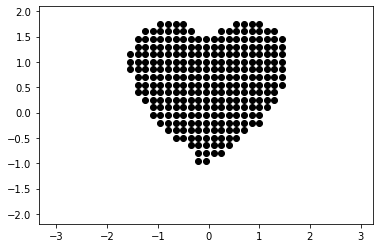

In [31]:
plt.axis('equal')

c = np.r_[-2:2:0.15]

XY = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])

Z = model.predict(XY)

for (x, y), z in zip(XY, Z):
  plt.scatter(x, y, c='black' if z[0] >= 0.5 else 'white')
plt.show()